In [33]:
pip install opencv-python tensorflow keras imutils mediapipe


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [34]:
pip install opencv-python mediapipe scikit-learn joblib numpy


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



Category: closed


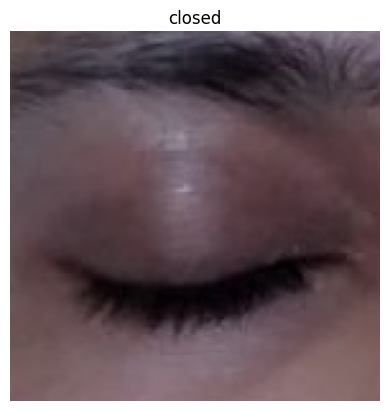

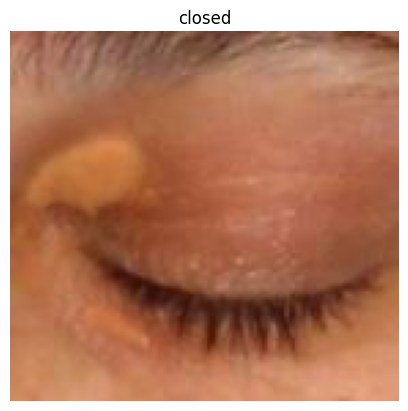

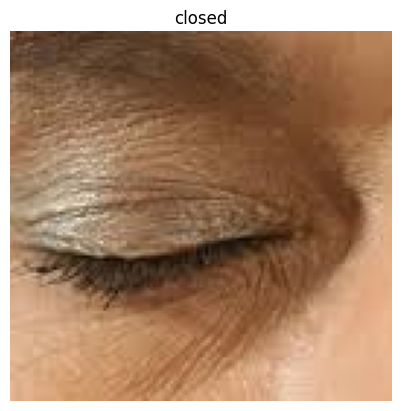


Category: open


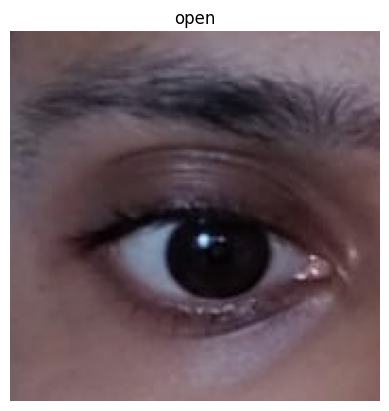

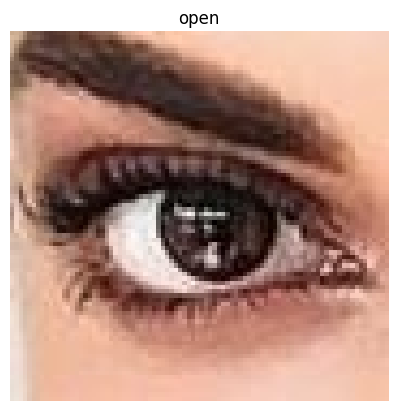

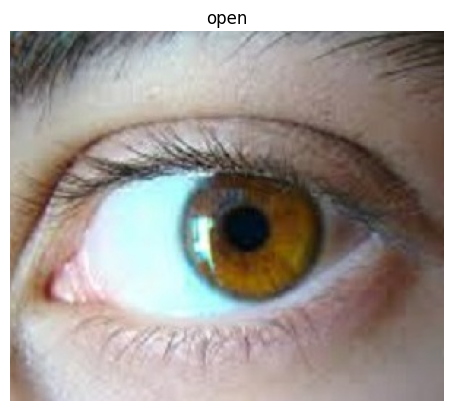


Category: yawn


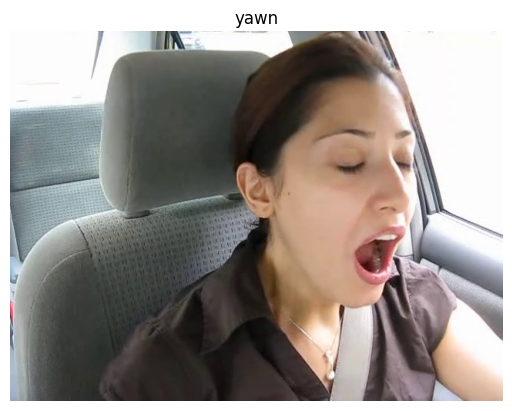

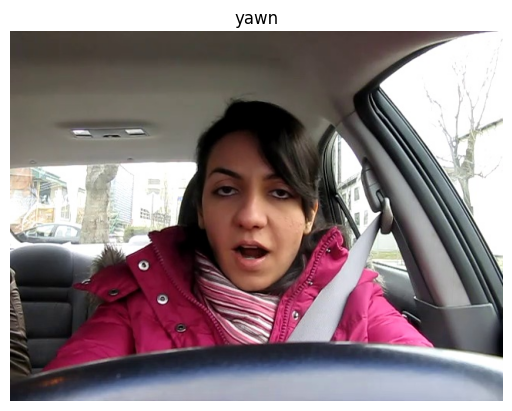

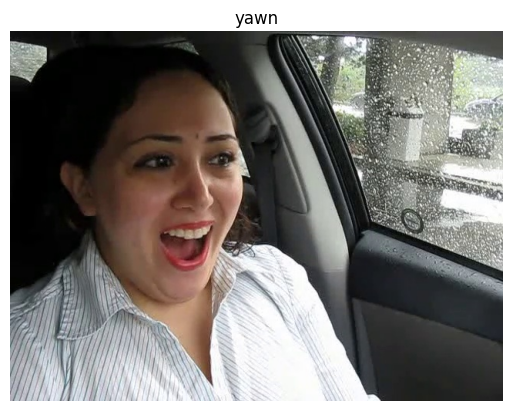


Category: no_yawn


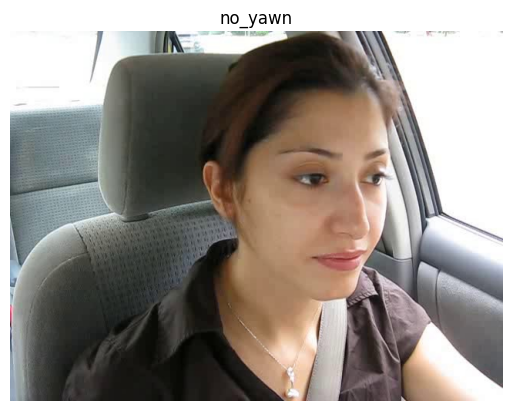

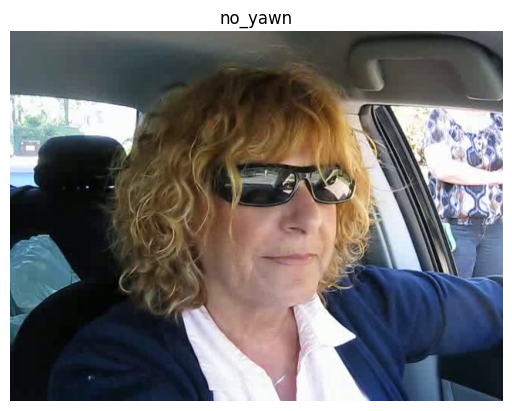

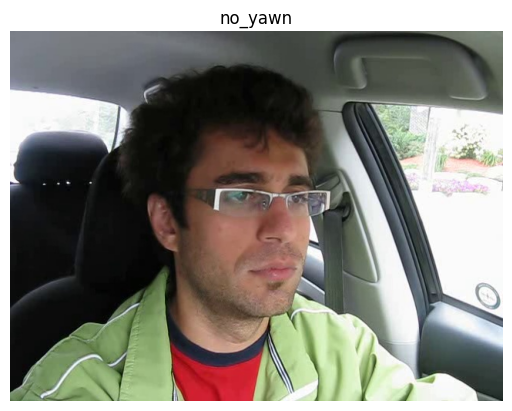

In [35]:
import os
import cv2
import matplotlib.pyplot as plt

def show_sample_images(base_path, categories, num=3):
    for category in categories:
        folder = os.path.join(base_path, category)
        images = os.listdir(folder)[:num]
        print(f"\nCategory: {category}")
        for img_name in images:
            img_path = os.path.join(folder, img_name)
            img = cv2.imread(img_path)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(category)
            plt.axis('off')
            plt.show()

# Example usage:
train_path = 'dataset_new/train'
categories = ['closed', 'open', 'yawn', 'no_yawn']
show_sample_images(train_path, categories)


In [36]:
import cv2
import dlib
import numpy as np
import os
import time

# Create folders (ensure this part remains if you need it)
os.makedirs('capture_image/alert', exist_ok=True)
os.makedirs('capture_image/drowsy', exist_ok=True)
os.makedirs('capture_image/yawning', exist_ok=True) # Create folder for yawning
os.makedirs('capture_image/distracted', exist_ok=True) # Create folder for distracted

# Load model (ensure this part remains)
predictor_path = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

# Indices (ensure this part remains)
LEFT_EYE_IDX = [36, 37, 38, 39, 40, 41]
RIGHT_EYE_IDX = [42, 43, 44, 45, 46, 47]
MOUTH_IDX = [60, 62, 64, 66]  # inner mouth

# --- Constants ---
EAR_THRESH = 0.20
MAR_THRESH = 0.7
YAW_THRESH = 20  # Degrees
LOOKING_AWAY_THRESH = 20  # Pixels
FRAME_WINDOW = 10  # For temporal averaging

# --- Helper Functions ---
def euclidean(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

def calculate_ear(landmarks, eye_indices):
    A = euclidean(landmarks[eye_indices[1]], landmarks[eye_indices[5]])
    B = euclidean(landmarks[eye_indices[2]], landmarks[eye_indices[4]])
    C = euclidean(landmarks[eye_indices[0]], landmarks[eye_indices[3]])
    return (A + B) / (2.0 * C)

def calculate_mar(landmarks):
    A = euclidean(landmarks[MOUTH_IDX[1]], landmarks[MOUTH_IDX[3]])
    B = euclidean(landmarks[MOUTH_IDX[0]], landmarks[MOUTH_IDX[2]])
    return A / B

def calculate_mouth_height(landmarks):
    A = euclidean(landmarks[62], landmarks[66])
    B = euclidean(landmarks[60], landmarks[64])
    return (A + B) / 2

def is_looking_away(landmarks):
    nose = landmarks[30]
    chin = landmarks[8]
    dx = abs(nose[0] - chin[0])
    return dx > LOOKING_AWAY_THRESH

def calculate_head_pose(landmarks, frame):
    # (Simplified - requires camera calibration for accuracy)
    # This is a placeholder; you'll need a robust implementation
    # using cv2.solvePnP or dlib's pose estimation
    nose = np.array(landmarks[30], dtype=np.float32)
    chin = np.array(landmarks[8], dtype=np.float32)
    yaw = np.arctan2(nose[0] - chin[0], frame.shape[1]) * 180 / np.pi
    return yaw

# --- Main Class ---
class DriverState:
    def __init__(self):
        self.ear_history = []
        self.mar_history = []
        self.yaw_history = []
        self.looking_away_history = [] # History for looking away
        self.drowsy_frames = 0
        self.yawn_frames = 0
        self.looking_away_frames = 0 # Counter for consecutive looking away frames

    def update(self, ear, mar, yaw, looking_away):
        self.ear_history.append(ear)
        self.mar_history.append(mar)
        self.yaw_history.append(yaw)
        self.looking_away_history.append(looking_away) # Store boolean in history

        if len(self.ear_history) > FRAME_WINDOW:
            self.ear_history.pop(0)
        if len(self.mar_history) > FRAME_WINDOW:
            self.mar_history.pop(0)
        if len(self.yaw_history) > FRAME_WINDOW:
            self.yaw_history.pop(0)
        if len(self.looking_away_history) > FRAME_WINDOW:
            self.looking_away_history.pop(0)

    def is_drowsy(self):
        avg_ear = np.mean(self.ear_history) if self.ear_history else 1.0
        return avg_ear < EAR_THRESH

    def is_yawning(self):
        avg_mar = np.mean(self.mar_history) if self.mar_history else 0.0
        return avg_mar > MAR_THRESH

    def is_distracted(self):
        avg_yaw = np.mean(self.yaw_history) if self.yaw_history else 0.0
        return abs(avg_yaw) > YAW_THRESH

    def is_looking_away(self):
        # Check if a significant portion of the recent frames indicate looking away
        return np.mean(self.looking_away_history) > 0.6 # Adjust threshold as needed

# --- Initialize ---
cap = cv2.VideoCapture(0)
last_save_time = 0
SAVE_INTERVAL = 2  # seconds
driver_state = DriverState()  # Initialize the DriverState object

# --- Main Loop ---
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    for face in faces:
        shape = predictor(gray, face)
        landmarks = [(p.x, p.y) for p in shape.parts()]

        left_ear = calculate_ear(landmarks, LEFT_EYE_IDX)
        right_ear = calculate_ear(landmarks, RIGHT_EYE_IDX)
        ear = (left_ear + right_ear) / 2.0

        mar = calculate_mar(landmarks)
        yaw = calculate_head_pose(landmarks, frame)  # Placeholder
        looking_away_flag = is_looking_away(landmarks)

        driver_state.update(ear, mar, yaw, looking_away_flag) # Pass looking_away flag


        # Display metrics
        cv2.putText(frame, f'EAR: {ear:.2f}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
        cv2.putText(frame, f'MAR: {mar:.2f}', (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
        cv2.putText(frame, f'Yaw: {yaw:.2f}', (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)  # Display yaw
        cv2.putText(frame, f'Looking Away: {driver_state.is_looking_away()}', (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)  # Display looking_away state


        # Logic to classify and display alerts
        current_time = time.time()
        state = "Alert" #default

        if driver_state.is_drowsy():
            state = "Drowsy"
        elif driver_state.is_yawning():
            state = "Yawning"
        elif driver_state.is_distracted() or driver_state.is_looking_away():
            state = "Distracted" #highest priority



        # Save every few seconds
        if current_time - last_save_time > SAVE_INTERVAL:
            filename = f"capture_image/{state.lower()}/frame_{int(current_time)}.jpg"
            cv2.imwrite(filename, frame)
            print(f"Saved {state} image:", filename)
            last_save_time = current_time

        # Draw facial landmarks for eyes and mouth
        for idx in LEFT_EYE_IDX:
            cv2.circle(frame, landmarks[idx], 2, (0, 255, 0), -1) # Green for left eye
        for idx in RIGHT_EYE_IDX:
            cv2.circle(frame, landmarks[idx], 2, (255, 0, 0), -1) # Blue for right eye
        for idx in MOUTH_IDX:
            cv2.circle(frame, landmarks[idx], 2, (255, 255, 0), -1) # Yellow for mouth

    cv2.imshow("Driver Monitoring", frame)

    key = cv2.waitKey(1)
    if key == 27:  # ESC
        break

cap.release()
cv2.destroyAllWindows()

Saved Alert image: capture_image/alert/frame_1745575454.jpg
Saved Alert image: capture_image/alert/frame_1745575456.jpg
Saved Alert image: capture_image/alert/frame_1745575458.jpg
Saved Alert image: capture_image/alert/frame_1745575460.jpg
Saved Alert image: capture_image/alert/frame_1745575462.jpg
Saved Alert image: capture_image/alert/frame_1745575464.jpg
Saved Alert image: capture_image/alert/frame_1745575466.jpg


In [37]:

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# --- Constants ---
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
SEED = 42
EYE_EPOCHS = 50
DRIVER_EPOCHS = 50

# --- Data Generators for Eye State (Open/Closed) ---
train_datagen_eye = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15  # Slightly larger validation split
)

train_eye = train_datagen_eye.flow_from_directory(
    'dataset_new/train/',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=['open', 'closed'],
    subset='training',
    seed=SEED
)

val_eye = train_datagen_eye.flow_from_directory(
    'dataset_new/train/',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=['open', 'closed'],
    subset='validation',
    seed=SEED
)

test_datagen_eye = ImageDataGenerator(rescale=1./255)
test_eye = test_datagen_eye.flow_from_directory(
    'capture_image',  # Assuming 'capture_image' has 'open' and 'closed' for eye test
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=['open', 'closed'],
    shuffle=False,
    seed=SEED
)


Found 1050 images belonging to 2 classes.
Found 184 images belonging to 2 classes.
Found 218 images belonging to 2 classes.


In [38]:

# --- Model for Eye State (Open/Closed) - Slightly Increased Complexity & Regularization ---
model_eye = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.35),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # 2 classes: open & closed
])

model_eye.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks_eye = [
    EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True), # Increased patience
    ModelCheckpoint('best_eye_model.keras', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=4, verbose=1) # Adjusted LR reduction
]

history_eye = model_eye.fit(
    train_eye,
    validation_data=val_eye,
    epochs=EYE_EPOCHS,
    callbacks=callbacks_eye
)



C:\Users\sanke\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\sanke\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 305ms/step - accuracy: 0.7527 - loss: 0.6407 - val_accuracy: 0.5000 - val_loss: 0.9526 - learning_rate: 0.0010
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 256ms/step - accuracy: 0.8586 - loss: 0.3526 - val_accuracy: 0.5000 - val_loss: 1.3448 - learning_rate: 0.0010
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 253ms/step - accuracy: 0.8999 - loss: 0.2613 - val_accuracy: 0.5000 - val_loss: 1.4869 - learning_rate: 0.0010
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 249ms/step - accuracy: 0.9144 - loss: 0.2384 - val_accuracy: 0.5000 - val_loss: 2.2360 - learning_rate: 0.0010
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9206 - loss: 0.2013 
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 290ms/step - accuracy: 0.9206 - loss: 0.2011 - val_accuracy: 0.5000 - val_loss: 2.3692 - learning_rate: 0.0010
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 253ms/step - accuracy: 0.9281 - loss: 0.1684 

In [39]:

print("\n--- Evaluation of Eye State Model ---")
loaded_model_eye = tf.keras.models.load_model('best_eye_model.keras')
test_loss_eye, test_acc_eye = loaded_model_eye.evaluate(test_eye)
print(f"Eye State Test Accuracy: {test_acc_eye * 100:.2f}%")



--- Evaluation of Eye State Model ---
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9362 - loss: 0.1078 
Eye State Test Accuracy: 95.87%


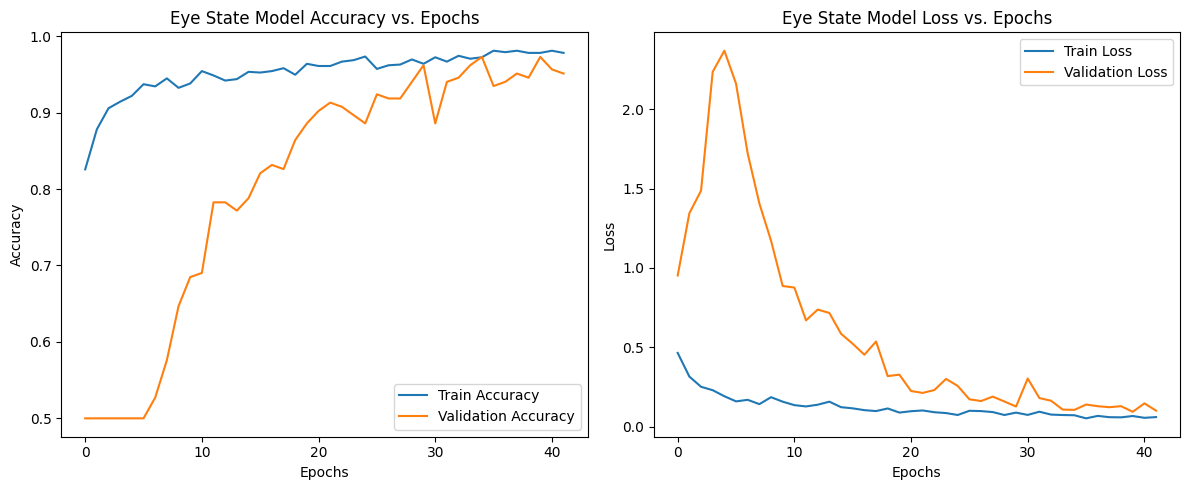

In [40]:

# --- Plotting History for Eye State Model ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_eye.history['accuracy'], label='Train Accuracy')
plt.plot(history_eye.history['val_accuracy'], label='Validation Accuracy')
plt.title('Eye State Model Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_eye.history['loss'], label='Train Loss')
plt.plot(history_eye.history['val_loss'], label='Validation Loss')
plt.title('Eye State Model Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import os

# --- Constants ---
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
SEED = 42
DRIVER_EPOCHS = 100
L2_REG = 0.0001  # Small L2 regularization

# --- Data Loading and Splitting (Same as before) ---
data_dir = 'driver_state_dataset/train/'
alert_dir = os.path.join(data_dir, 'alert')
drowsy_dir = os.path.join(data_dir, 'drowsy')
alert_images = [os.path.join(alert_dir, f) for f in os.listdir(alert_dir) if os.path.isfile(os.path.join(alert_dir, f))]
drowsy_images = [os.path.join(drowsy_dir, f) for f in os.listdir(drowsy_dir) if os.path.isfile(os.path.join(drowsy_dir, f))]
all_images = alert_images + drowsy_images
labels = [0] * len(alert_images) + [1] * len(drowsy_images)
train_images, val_test_images, train_labels, val_test_labels = train_test_split(all_images, labels, test_size=0.3, random_state=SEED, stratify=labels)
val_images, test_images, val_labels, test_labels = train_test_split(val_test_images, val_test_labels, test_size=0.5, random_state=SEED, stratify=val_test_labels)

# --- Calculate Class Weights (Same as before) ---
alert_count = labels.count(0)
drowsy_count = labels.count(1)
total_samples = len(labels)
weight_for_alert = (1 / alert_count) * (total_samples / 2.0) if alert_count > 0 else 1.0
weight_for_drowsy = (1 / drowsy_count) * (total_samples / 2.0) if drowsy_count > 0 else 1.0
class_weights_driver = {0: weight_for_alert, 1: weight_for_drowsy}
print("Class Weights:", class_weights_driver)

# --- Data Generators with Moderate Augmentation ---
train_datagen_driver = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen_driver = ImageDataGenerator(rescale=1./255)
test_datagen_driver = ImageDataGenerator(rescale=1./255)

def data_generator_weighted(images, labels, datagen, batch_size, class_weights):
    num_samples = len(images)
    while True:
        indices = np.random.permutation(num_samples)
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]
            batch_images = [tf.keras.preprocessing.image.load_img(img, target_size=IMG_SIZE) for img in np.array(images)[batch_indices]]
            batch_images = np.array([tf.keras.preprocessing.image.img_to_array(img) for img in batch_images])
            batch_labels = tf.keras.utils.to_categorical(np.array(labels)[batch_indices], num_classes=2)
            batch_weights = np.array([class_weights[label] for label in np.array(labels)[batch_indices]])
            yield (batch_images, batch_labels, batch_weights)

def data_generator(images, labels, datagen, batch_size):
    num_samples = len(images)
    while True:
        indices = np.random.permutation(num_samples)
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]
            batch_images = [tf.keras.preprocessing.image.load_img(img, target_size=IMG_SIZE) for img in np.array(images)[batch_indices]]
            batch_images = np.array([tf.keras.preprocessing.image.img_to_array(img) for img in batch_images])
            batch_labels = tf.keras.utils.to_categorical(np.array(labels)[batch_indices], num_classes=2)
            yield (batch_images, batch_labels)

train_generator_driver = data_generator_weighted(train_images, train_labels, train_datagen_driver, BATCH_SIZE, class_weights_driver)
val_generator_driver = data_generator_weighted(val_images, val_labels, val_datagen_driver, BATCH_SIZE, class_weights_driver)
test_generator_driver = data_generator(test_images, test_labels, test_datagen_driver, BATCH_SIZE)

# --- Deliberately Small Model ---
model_driver = models.Sequential([
    layers.Conv2D(8, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), padding='same', kernel_regularizer=regularizers.l2(L2_REG)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(L2_REG)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(L2_REG)),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model_driver.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks_driver = [
    EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True),
    ModelCheckpoint('best_driver_model_target_accuracy_v5.keras', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=7, verbose=1)
]

history_driver = model_driver.fit(
    train_generator_driver,
    steps_per_epoch=len(train_images) // BATCH_SIZE,
    validation_data=val_generator_driver,
    validation_steps=len(val_images) // BATCH_SIZE,
    epochs=DRIVER_EPOCHS,
    callbacks=callbacks_driver,
)



Class Weights: {0: 7.424657534246575, 1: 0.5361028684470821}


C:\Users\sanke\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - accuracy: 0.4228 - loss: 111.7527 - val_accuracy: 0.0656 - val_loss: 0.6924 - learning_rate: 0.0010
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.0648 - loss: 0.6887 - val_accuracy: 0.0625 - val_loss: 0.6777 - learning_rate: 0.0010
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.0625 - loss: 0.6778 - val_accuracy: 0.0531 - val_loss: 0.6336 - learning_rate: 0.0010
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.0635 - loss: 0.6826 - val_accuracy: 0.0614 - val_loss: 0.6725 - learning_rate: 0.0010
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.0956 - loss: 0.7142 - val_accuracy: 0.0478 - val_loss: 0.6072 - learning_rate: 0.0010
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.0761 - loss: 0.7420 - val_accuracy: 0.0546 - val_loss: 0.6400 - learning_rate: 0.0010
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.0731 - loss:

In [ ]:
print("\n--- Evaluation of Alert/Drowsy Model ---")
loaded_model_driver = tf.keras.models.load_model('best_driver_model_target_accuracy_v5.keras')
test_loss_driver, test_acc_driver = loaded_model_driver.evaluate(test_generator_driver, steps=len(test_images) // BATCH_SIZE)
print(f"Alert/Drowsy Test Accuracy: {test_acc_driver * 100:.2f}%")

# --- Plotting History and Evaluation ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_driver.history['accuracy'], label='Train Accuracy')
plt.plot(history_driver.history['val_accuracy'], label='Validation Accuracy')
plt.title('Alert/Drowsy Model Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_driver.history['loss'], label='Train Loss')
plt.plot(history_driver.history['val_loss'], label='Validation Loss')
plt.title('Alert/Drowsy Model Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
y_pred_driver = loaded_model_driver.predict(test_generator_driver, steps=len(test_images) // BATCH_SIZE)
y_pred_classes_driver = np.argmax(y_pred_driver, axis=1)
y_true_driver = np.array(test_labels[:len(y_pred_classes_driver)])

print("\nClassification Report (Alert/Drowsy Model):")
print(classification_report(y_true_driver, y_pred_classes_driver, target_names=['alert', 'drowsy']))

cm_driver = confusion_matrix(y_true_driver, y_pred_classes_driver)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_driver, annot=True, fmt='d', cmap='Blues',
            xticklabels=['alert', 'drowsy'], yticklabels=['alert', 'drowsy'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Alert/Drowsy Model)')
plt.show()

In [32]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import dlib
from scipy.spatial import distance as dist
from imutils import face_utils
import time
import threading
import winsound  # For playing sound on Windows

# Load the trained model
model_path = 'best_driver_model.keras'  # Replace with your model path
try:
    model = load_model(model_path)
    print(f"Model loaded from: {model_path}")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# Access the camera
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not open camera.")
    exit()
else:
    print("Camera opened successfully.")

# Load classifiers
face_cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
eye_cascade_path = cv2.data.haarcascades + 'haarcascade_eye.xml'

try:
    face_cascade = cv2.CascadeClassifier(face_cascade_path)
    eye_cascade = cv2.CascadeClassifier(eye_cascade_path)
    print(f"Face cascade loaded from: {face_cascade_path}")
    print(f"Eye cascade loaded from: {eye_cascade_path}")
except Exception as e:
    print(f"Error loading cascades: {e}")
    exit()

# Load dlib predictor
predictor_path = "shape_predictor_68_face_landmarks.dat"  # Replace with your predictor path
try:
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)
    print(f"Dlib predictor loaded from: {predictor_path}")
except Exception as e:
    print(f"Error loading dlib: {e}")
    exit()

# Constants and variables
EAR_THRESHOLD = 0.20
MAR_THRESHOLD = 0.5
LEFT_EYE_POINTS = [36, 37, 38, 39, 40, 41]
RIGHT_EYE_POINTS = [42, 43, 44, 45, 46, 47]
MOUTH_POINTS = [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
YAWN_MIN_FRAMES = 12
DROWSY_ALERT_TIME = 3  # Seconds of continuous drowsiness to trigger alert
drowsy_start_time = None
yawn_counter = 0
alert_sound_file = "mixkit-alert-alarm-1005.wav"  # Replace with the path to your alarm sound file

def play_alert_sound(file_path):
    try:
        winsound.PlaySound(file_path, winsound.SND_ASYNC)
        print("Playing alert sound!")
    except Exception as e:
        print(f"Error playing sound: {e}")

def eye_aspect_ratio(eye):
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    C = dist.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

def mouth_aspect_ratio(mouth):
    A = dist.euclidean(mouth[2], mouth[10])
    B = dist.euclidean(mouth[3], mouth[9])
    C = dist.euclidean(mouth[4], mouth[8])
    D = dist.euclidean(mouth[0], mouth[6])
    mar = (A + B + C) / (2.0 * D)
    return mar

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Failed to capture frame.")
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        face_roi_gray = gray[y:y + h, x:x + w]
        face_roi_color = frame[y:y + h, x:x + w]

        rect = dlib.rectangle(int(x), int(y), int(x + w), int(y + h))
        try:
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)

            leftEye = shape[LEFT_EYE_POINTS]
            rightEye = shape[RIGHT_EYE_POINTS]
            mouth = shape[MOUTH_POINTS]
            leftEAR = eye_aspect_ratio(leftEye)
            rightEAR = eye_aspect_ratio(rightEye)
            ear = (leftEAR + rightEAR) / 2.0
            mar = mouth_aspect_ratio(mouth)

            for (lx, ly) in leftEye:
                cv2.circle(frame, (lx, ly), 1, (0, 0, 255), -1)
            for (rx, ry) in rightEye:
                cv2.circle(frame, (rx, ry), 1, (0, 0, 255), -1)
            for (mx, my) in mouth:
                cv2.circle(frame, (mx, my), 1, (0, 0, 255), -1)

            state = "Alert"
            if ear < EAR_THRESHOLD:
                if drowsy_start_time is None:
                    drowsy_start_time = time.time()
                elif time.time() - drowsy_start_time > DROWSY_ALERT_TIME:
                    state = "Drowsy"
                    cv2.putText(frame, "DROWSY - ALERT!", (x, y - 40), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
                    threading.Thread(target=play_alert_sound, args=(alert_sound_file,)).start()
                else:
                    state = "Drowsy"
                    cv2.putText(frame, "Drowsy", (x, y - 40), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
            else:
                drowsy_start_time = None

            if mar > MAR_THRESHOLD:
                yawn_counter += 1
                if yawn_counter > YAWN_MIN_FRAMES:
                    state = "Yawning"
                    cv2.putText(frame, "YAWNING!", (x, y - 70), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
            else:
                yawn_counter = 0

            try:
                processed_face = cv2.resize(face_roi_color, (64, 64))
                processed_face = processed_face / 255.0
                processed_face = np.expand_dims(processed_face, axis=0)
                prediction = model.predict(processed_face)
                predicted_class_index = np.argmax(prediction)
                class_labels = ['alert', 'attentive', 'drowsy']  # Ensure this matches your model's output
                if state == "Alert": # Only update state if not already drowsy or yawning
                    if class_labels[predicted_class_index] == 'drowsy':
                        if drowsy_start_time is None:
                            drowsy_start_time = time.time()
                        elif time.time() - drowsy_start_time > DROWSY_ALERT_TIME:
                            state = "Drowsy (CNN)"
                            cv2.putText(frame, "DROWSY (CNN) - ALERT!", (x, y - 90), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 100, 255), 2)
                            threading.Thread(target=play_alert_sound, args=(alert_sound_file,)).start()
                        else:
                            state = "Drowsy (CNN)"
                            cv2.putText(frame, "Drowsy (CNN)", (x, y - 90), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 100, 255), 2)
                    else:
                        state = class_labels[predicted_class_index].capitalize()
                        cv2.putText(frame, f'State: {state}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
                elif state != "Drowsy" and state != "Yawning":
                    cv2.putText(frame, f'State: {state}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)


            except Exception as e:
                print(f"Error during model prediction: {e}")
                cv2.putText(frame, f'State: {state}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        except Exception as e:
            print(f"Error during face/landmark processing: {e}")
            cv2.putText(frame, "Error", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    cv2.imshow('Real-time Drowsiness Detection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Model loaded from: best_driver_model.keras
Camera opened successfully.
Face cascade loaded from: C:\Users\sanke\AppData\Roaming\Python\Python312\site-packages\cv2\data\haarcascade_frontalface_default.xml
Eye cascade loaded from: C:\Users\sanke\AppData\Roaming\Python\Python312\site-packages\cv2\data\haarcascade_eye.xml
Dlib predictor loaded from: shape_predictor_68_face_landmarks.dat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━